# Exlporatory analysis of the UK Power Networks led Low Carbon London project dataset

This Notebook deal with the following exploratory elements:
1. Descriptives of the full and balanced datasets
2. Analysis of Seasonal kWh consumption
3. Analysis of ToU vs Standard consumers' kWh consumption
4. Analysis of kWh consumption during Weekday and Weekends
5. Analysis of morning, evening, night kWh consumption
6. Analysis of kWh during holiday and non-holiday periods
7. Analysis of CACI groups
8. Analysis of CACI sub-groups
9. Weather variables to include in ML models

In [1]:
# Data processing
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical modelling
import scipy
import statsmodels.api as sm
from scipy import stats

## Descriptives of full dataset

In [2]:
df = pd.read_csv(r"D:\Msc BIM\Master Thesis Trajectory\Data\UK Power Networks\Processed_Date_UK_Power_Data.csv", sep="\t")
df = df.iloc[:,[1,4]]
df = df[df.iloc[:,1] != 'null']
df = df[df.iloc[:,1] != 'Null']
df = df.values
df[:,1] = df[:,1].astype(np.float)
print('Count of observations = '+ str(len(df[:,1])))
print('Count of unique smart meters = '+ str(len(set(list(df[:,0])))))
print('mean of balanced dataset = ' + str(np.mean(df[:,1])))
print('Standard Deviation of balanced dataset = ' + str(np.std(df[:,1])))
print('Minimum of balanced dataset = ' + str(np.min(df[:,1])))
print('Maximum of balanced dataset = ' + str(np.max(df[:,1])))
print('Count of 0 kWh observations = '+  str(len(df[df[:,1] == 0])))

Count of observations = 101534135
Count of unique smart meters = 5550
mean of balanced dataset = 0.21491780495947868
Standard Deviation of balanced dataset = 0.30295950951967265
Minimum of balanced dataset = 0.0
Maximum of balanced dataset = 10.7609997
Count of 0 kWh observations = 1272206


## Descriptives of Balanced Dataset

In [3]:
df = pd.read_csv("All_Data.csv", sep="\t")
# Remove observations not belonging to a Caci Group
df = df[df.Acorn != '0']
df = df[df.Acorn != 'ACORN-U']
# convert to numpy and count amount of unique smart meters
df = df.values
print('Count of observations = '+ str(len(df[:,22])))
print('Count of unique smart meters = '+ str(len(set(list(df[:,1])))))
print('mean of balanced dataset = ' + str(np.mean(df[:,22])))
print('Standard Deviation of balanced dataset = ' + str(np.std(df[:,22])))
print('Minimum of balanced dataset = ' + str(np.min(df[:,22])))
print('Maximum of balanced dataset = ' + str(np.max(df[:,22])))
print('Count of 0 kWh observations = '+  str(len(df[df[:,22] == 0])))

Count of observations = 17315560
Count of unique smart meters = 908
mean of balanced dataset = 0.22201439716285024
Standard Deviation of balanced dataset = 0.32507996449440085
Minimum of balanced dataset = 0.0
Maximum of balanced dataset = 9.140999800000001
Count of 0 kWh observations = 196374


## Analysis of Seasonal kWh consumption

In [4]:
df = pd.read_csv("All_Data.csv", sep="\t")
df = df[df.Acorn != '0']
df= df[df.Acorn != 'ACORN-U']

In [5]:
df.head()

,Unnamed: 0,LCLid,Acorn,Year,Month,Day,Hour,DateTime,humidity,pressure,...,windSpeed,StdorToU,isAutumn,isSpring,isWinter,isHoliday,isEvening,isNight,isWeekend,KWH_hh
0,0,MAC000323,ACORN-A,2012,12,1,0.0,2012-12-01 00:00,0.934,1014.592,...,2.908,1,0,0,1,0,0,1,1,0.448
1,1,MAC001528,ACORN-A,2012,12,1,0.0,2012-12-01 00:00,0.934,1014.592,...,2.908,1,0,0,1,0,0,1,1,0.157
2,2,MAC001710,ACORN-A,2012,12,1,0.0,2012-12-01 00:00,0.934,1014.592,...,2.908,1,0,0,1,0,0,1,1,0.257
3,3,MAC001819,ACORN-A,2012,12,1,0.0,2012-12-01 00:00,0.934,1014.592,...,2.908,1,0,0,1,0,0,1,1,0.344
4,4,MAC002563,ACORN-A,2012,12,1,0.0,2012-12-01 00:00,0.934,1014.592,...,2.908,1,0,0,1,0,0,1,1,0.181


In [6]:
# Create subsets of seasonal data
Winter = df[(df['isSpring'] == 0) & (df['isWinter'] == 1) & (df['isAutumn'] == 0)]
Summer = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Spring = df[(df['isSpring'] == 1) & (df['isWinter'] == 0) & (df['isAutumn'] == 0)]
Autumn = df[(df['isSpring'] == 0) & (df['isWinter'] == 0) & (df['isAutumn'] == 1)]

In [7]:
Sum_day = Summer.groupby('Hour').mean().iloc[:,-1] 
Win_day = Winter.groupby('Hour').mean().iloc[:,-1] 
Spr_day = Spring.groupby('Hour').mean().iloc[:,-1] 
Aut_day = Autumn.groupby('Hour').mean().iloc[:,-1] 

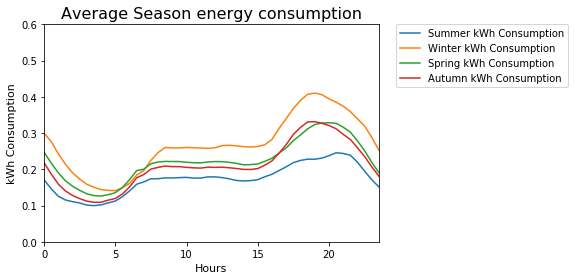

In [8]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, Sum_day, label = 'Summer kWh Consumption')
plt.plot(weekday_days, Win_day, label = 'Winter kWh Consumption')
plt.plot(weekday_days, Spr_day, label = 'Spring kWh Consumption')
plt.plot(weekday_days, Aut_day, label = 'Autumn kWh Consumption')
plt.axis((0,23.5,0.00,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Average Season energy consumption', fontsize=16)
plt.show()

In [9]:
# Return f-statistic and p-value
f, p = scipy.stats.f_oneway(Winter.loc[:,"KWH_hh"], Summer.loc[:,"KWH_hh"], Autumn.loc[:,"KWH_hh"], Spring.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 68734.5788524007
P-value: 0.0


## Analysis of kWh for Time of use vs. Standard consumers

In [10]:
# Remove variables from memory and create subsets of ToU vs. Standard consumers kWh data
del Winter, Summer, Spring, Autumn

ToU = df[(df['StdorToU'] == 0)]
Std = df[(df['StdorToU'] == 1)]
ToU_kWh = ToU.groupby('Hour').mean().iloc[:,-1]
Std_kWh = Std.groupby('Hour').mean().iloc[:,-1]

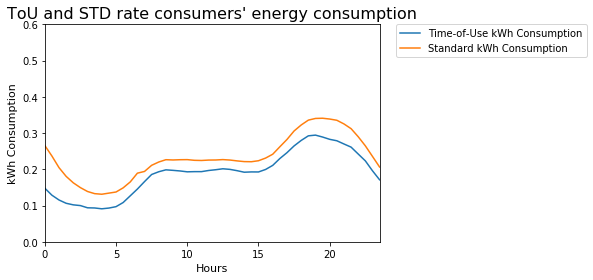

In [11]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, ToU_kWh, label = 'Time-of-Use kWh Consumption')
plt.plot(weekday_days, Std_kWh, label = 'Standard kWh Consumption')
plt.axis((0,23.5,0,.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('ToU and STD rate consumers\' energy consumption', fontsize=16)
plt.show()

In [12]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(ToU.loc[:,'KWH_hh'], Std.loc[:,'KWH_hh'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -229.9811407159731
p-value: 0.0


## Analysis of kWh consumption during Weekday and Weekends

In [13]:
# Remove variables from memory and create subsets of Weekday vs. Weekemd kWh data
del ToU, Std 

week_day = df[(df['isWeekend'] == 0)]
week_end = df[(df['isWeekend'] == 1)]
weekday = week_day.groupby('Hour').mean().iloc[:,-1]
weekend = week_end.groupby('Hour').mean().iloc[:,-1]

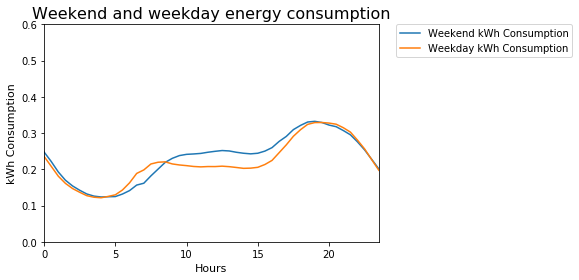

In [14]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, weekend, label = 'Weekend kWh Consumption')
plt.plot(weekday_days, weekday, label = 'Weekday kWh Consumption')
plt.axis((0,23.5,0.0,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Weekend and weekday energy consumption', fontsize=16)
plt.show()

In [15]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(week_day.loc[:,'KWH_hh'], week_end.loc[:,'KWH_hh'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: -62.55603608013155
p-value: 0.0


## Analysis of morning, evening, night kWh consumption

In [16]:
# Remove variables from memory and create subsets of day periods kWh data
del week_day, week_end

Morning = df[(df['isEvening'] == 0) & (df['isNight'] == 0)]
Evening = df[(df['isEvening'] == 1)]
Night = df[(df['isNight'] == 1)]

In [17]:
# Make hours comparable, within the range of 0:00 and 7:30 hours
Evening.Hour = Evening.Hour-12
Night.Hour[(Night.Hour >= 0) & (Night.Hour < 4)] = Night.Hour[(Night.Hour >= 0) & (Night.Hour < 4)] + 4
Night.Hour[Night.Hour > 19] = Night.Hour[Night.Hour > 19] -20
Morning.Hour = Morning.Hour-4

c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\gebruiker\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



In [18]:
Morning_kwh = Morning.groupby('Hour').mean().iloc[:,-1]
Evening_kwh = Evening.groupby('Hour').mean().iloc[:,-1]
Night_kwh = Night.groupby('Hour').mean().iloc[:,-1]

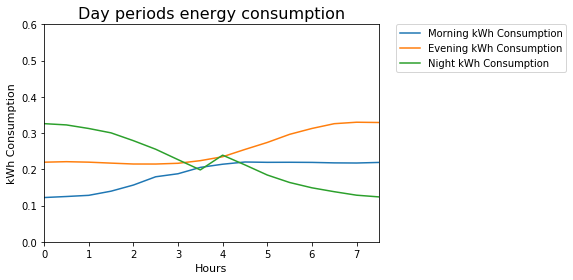

In [19]:
dayperiods = np.arange(0,8,.5)
plt.plot(dayperiods, Morning_kwh, label = 'Morning kWh Consumption')
plt.plot(dayperiods, Evening_kwh, label = 'Evening kWh Consumption')
plt.plot(dayperiods, Night_kwh, label = 'Night kWh Consumption')
plt.axis((0,7.5,0.0,0.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title('Day periods energy consumption', fontsize=16)
plt.show()

In [20]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(Evening.loc[:,"KWH_hh"], Morning.loc[:,"KWH_hh"], Night.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 66781.26192074934
P-value: 0.0


## Analysis of kWh during holiday and non-holiday periods

In [21]:
# Remove variables from memory and create subsets of day periods kWh data
del Morning, Evening, Night

Holiday = df[df['isHoliday'] == 1]
Non_Holiday = df[df['isHoliday'] == 0]

In [22]:
Holiday_kwh = Holiday.groupby('Hour').mean().iloc[:,-1]
Non_Holiday_kwh = Non_Holiday.groupby('Hour').mean().iloc[:,-1]

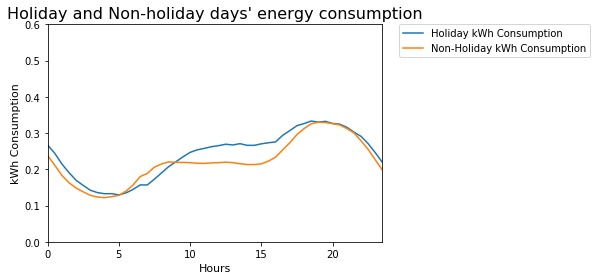

In [23]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, Holiday_kwh, label = 'Holiday kWh Consumption')
plt.plot(weekday_days, Non_Holiday_kwh, label = 'Non-Holiday kWh Consumption')
plt.axis((0,23.5,0,.6))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title("Holiday and Non-holiday day energy consumption", fontsize=16)
plt.show()

In [24]:
# Return t-statistic and p-value
t, p = scipy.stats.ttest_ind(Holiday.loc[:,'KWH_hh'], Non_Holiday.loc[:,'KWH_hh'], axis=0, equal_var=True, nan_policy='omit')
print("t-statistic:", t)
print("p-value:", p)

t-statistic: 38.94415876805902
p-value: 0.0


## Descrptives  of Cluster data

In [25]:
# Remove variables from memory and create subsets of CACI main categories kWh data
del Holiday, Non_Holiday

AA = df[(df.Acorn == 'ACORN-A') | (df.Acorn == 'ACORN-B') | (df.Acorn == 'ACORN-C')]
RP = df[(df.Acorn == 'ACORN-D') | (df.Acorn == 'ACORN-E')]
CC = df[(df.Acorn == 'ACORN-F') | (df.Acorn == 'ACORN-G') | (df.Acorn == 'ACORN-H') | (df.Acorn == 'ACORN-I') | (df.Acorn == 'ACORN-J')]
FS = df[(df.Acorn == 'ACORN-K') | (df.Acorn == 'ACORN-L') | (df.Acorn == 'ACORN-M') | (df.Acorn == 'ACORN-N')]
UA = df[(df.Acorn == 'ACORN-O') | (df.Acorn == 'ACORN-P') | (df.Acorn == 'ACORN-Q')]

In [26]:
AA_KWH = AA.groupby('Hour').mean().iloc[:,-1]
RP_KWH = RP.groupby('Hour').mean().iloc[:,-1]
CC_KWH = CC.groupby('Hour').mean().iloc[:,-1]
FS_KWH = FS.groupby('Hour').mean().iloc[:,-1]
UA_KWH = UA.groupby('Hour').mean().iloc[:,-1]

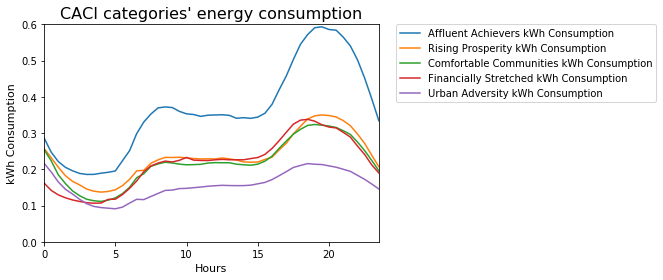

In [27]:
weekday_days = np.arange(0,24,.5)
plt.plot(weekday_days, AA_KWH, label = 'Affluent Achievers kWh Consumption')
plt.plot(weekday_days, RP_KWH, label = 'Rising Prosperity kWh Consumption')
plt.plot(weekday_days, CC_KWH, label = 'Comfortable Communities kWh Consumption')
plt.plot(weekday_days, FS_KWH, label = 'Financially Stretched kWh Consumption')
plt.plot(weekday_days, UA_KWH, label = 'Urban Adversity kWh Consumption')
plt.axis((0,23.5,0.0,0.60))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Hours', fontsize=11)
plt.ylabel('kWh Consumption', fontsize=11)
plt.title("CACI categories' energy consumption", fontsize=16)
plt.show()

In [28]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(AA.loc[:,"KWH_hh"], RP.loc[:,"KWH_hh"], CC.loc[:,"KWH_hh"], FS.loc[:,"KWH_hh"], UA.loc[:,"KWH_hh"])
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 79029.82184759571
P-value: 0.0


## Analysis of CACI sub-groups

In [29]:
# Remove variables from memory
del AA, RP, CC, FS, UA

In [30]:
# Create and apply function that prints out summary statistic per CACI group
def descriptives(df,string):
    df = df[(df['Acorn'] == 'ACORN-'+string)]
    # convert to numpy and count amount of unique smart meters
    df = df.values
    print(string)
    print('Number of Smart Meter readings is ' + str(len(df)))
    print('Count of unique smart meters is '+ str(len(set(list(df[:,1])))))
    print('mean of Smart Meter readings is ' + str(np.mean(df[:,22])))
    print('Standard Deviation of Smart Meter readings is ' + str(np.std(df[:,22])))
    print('Minimum of Smart Meter readings is ' + str(np.min(df[:,22])))
    print('Maximum of Smart Meter readings is ' + str(np.max(df[:,22])))
    print('N. of 0 kWh readings per meter is ' + str(len(df[df[:,-1]== 0])))
caci = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q']
[descriptives(df,group) for group in caci]

A
Number of Smart Meter readings is 457680
Count of unique smart meters is 24
mean of Smart Meter readings is 0.4757336829671285
Standard Deviation of Smart Meter readings is 0.6619990486730412
Minimum of Smart Meter readings is 0.0
Maximum of Smart Meter readings is 9.140999800000001
N. of 0 kWh readings per meter is 3734
B
Number of Smart Meter readings is 114420
Count of unique smart meters is 6
mean of Smart Meter readings is 0.30386931481122403
Standard Deviation of Smart Meter readings is 0.3240991165748013
Minimum of Smart Meter readings is 0.0
Maximum of Smart Meter readings is 3.3789998999999997
N. of 0 kWh readings per meter is 632
C
Number of Smart Meter readings is 381400
Count of unique smart meters is 20
mean of Smart Meter readings is 0.24467911902438508
Standard Deviation of Smart Meter readings is 0.2947496728835068
Minimum of Smart Meter readings is 0.0
Maximum of Smart Meter readings is 4.566
N. of 0 kWh readings per meter is 4495
D
Number of Smart Meter readings is 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
# Create subsets of data by CACI sub-group
A = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-A']
B = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-B']
C = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-C']
D = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-D']
E = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-E']
F = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-F']
G = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-G']
H = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-H']
I = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-I']
J = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-J']
K = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-K']
L = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-L']
M = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-M']
N = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-N']
O = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-O']
P = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-P']
Q = df.loc[:, "KWH_hh"][df.Acorn == 'ACORN-Q']

In [32]:
# Return F-statistics and p-value
f, p = scipy.stats.f_oneway(A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q)
print("F-statistic:", f)
print("P-value:", p)

F-statistic: 34529.00413217599
P-value: 0.0


## Weather variables to include in ML models

In [33]:
del A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q

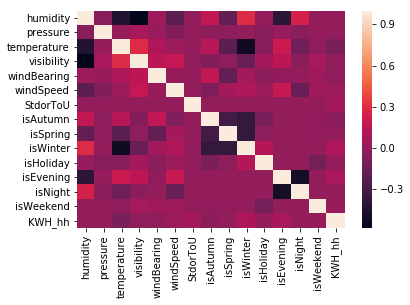

In [34]:
sns.heatmap(df[['humidity',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'StdorToU', 'isAutumn', 'isSpring', 'isWinter', 'isHoliday',
       'isEvening', 'isNight', 'isWeekend', 'KWH_hh']].corr())

In [35]:
def linearModel(df, latex=False):
    X = sm.add_constant(df[['humidity', 'pressure', 'temperature', 'visibility', 'windBearing',
       'windSpeed', 'StdorToU', 'isAutumn', 'isSpring', 'isWinter',
       'isHoliday', 'isEvening', 'isNight', 'isWeekend']])
    y = df['KWH_hh']
    est = sm.OLS(y,X).fit()
    if latex == False:
        print(est.summary())
    elif latex == True:
        print(est.summary().as_latex())

In [36]:
linearModel(df,False)

                            OLS Regression Results                            
Dep. Variable:                 KWH_hh   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                 3.142e+04
Date:                Wed, 06 Jun 2018   Prob (F-statistic):               0.00
Time:                        11:54:09   Log-Likelihood:            -4.8953e+06
No. Observations:            17315560   AIC:                         9.791e+06
Df Residuals:                17315545   BIC:                         9.791e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1517      0.002     73.380      

In [37]:
linearModel(df,True)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      KWH_hh      & \textbf{  R-squared:         } &       0.025     \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &       0.025     \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &   3.142e+04     \\
\textbf{Date:}             & Wed, 06 Jun 2018 & \textbf{  Prob (F-statistic):} &       0.00      \\
\textbf{Time:}             &     11:54:37     & \textbf{  Log-Likelihood:    } &  -4.8953e+06    \\
\textbf{No. Observations:} &     17315560     & \textbf{  AIC:               } &   9.791e+06     \\
\textbf{Df Residuals:}     &     17315545     & \textbf{  BIC:               } &   9.791e+06     \\
\textbf{Df Model:}         &          14      & \textbf{                     } &                 \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                     & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[